The dataset is available at 

* Afik, Eldad (2021): ridge directed ring detector. figshare. Dataset. https://doi.org/10.6084/m9.figshare.5119804.v1 

The manuscript describing the algorithm and the data:

* Afik, Eldad. 2015. “Robust and Highly Performant Ring Detection Algorithm for 3d Particle Tracking Using 2d Microscope Imaging.” Scientific Reports 5 (September): 13584. https://doi.org/10.1038/srep13584.

A python implementation of the algorithm: 

* https://github.com/eldad-a/ridge-directed-ring-detector

Some physics we learnt using it:

* Afik, Eldad, and Victor Steinberg. 2017. “On the Role of Initial Velocities in Pair Dispersion in a Microfluidic Chaotic Flow.” Nature Communications 8 (1). https://doi.org/10.1038/s41467-017-00389-8.



## FlyMovieFormat $\to$ png

### Installation

AStraw's motmot Fly Movie Format https://pypi.org/project/motmot.FlyMovieFormat/
```BASH
! pip install motmot.FlyMovieFormat
```

### Example
http://code.astraw.com/projects/motmot/fly-movie-format.html

```python
import motmot.FlyMovieFormat.FlyMovieFormat as FMF
import sys

fname = sys.argv[1]
fmf = FMF.FlyMovie(fname)
for frame_number in range(10):
    frame,timestamp = fmf.get_frame(frame_number)
```

# Read images from an FMF file

In [1]:
import motmot.FlyMovieFormat.FlyMovieFormat as FMF

In [2]:
fname = './80ppm78Sugar_2x2bin_exp4ms_gain10_20130217_152427.fmf'

## The source image in the Afik (2015) paper

In [3]:
# In the paper used `unprocessed_fig_46.png`
fmf = FMF.FlyMovie(fname)
_, timestamp_first = fmf.get_frame(0)
frame_number = 46
frame,timestamp = fmf.get_frame(frame_number)

In [4]:
from datetime import datetime as dt
To = dt.fromtimestamp(timestamp_first)

def get_time_from_To(timestamp):
    return dt.fromtimestamp(timestamp)-To

frame is 728 x 968 px


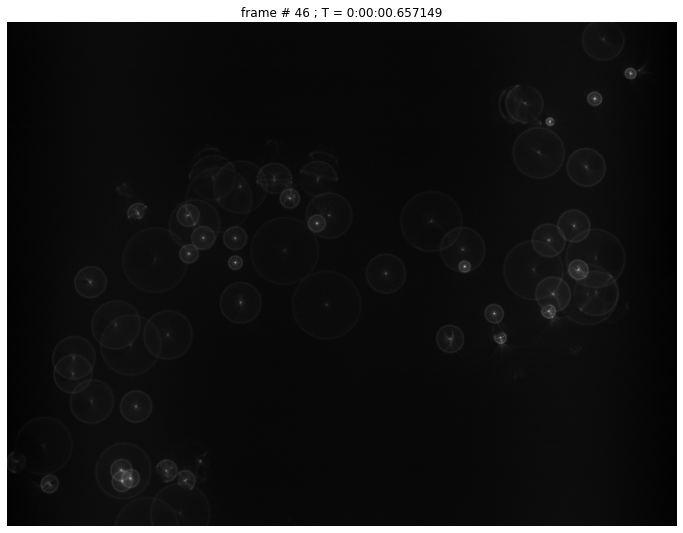

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,18))
plt.title(f'frame # {frame_number} ; T = {get_time_from_To(timestamp)}')
ax.imshow(frame, cmap=plt.cm.gray)
ax.axis('off');
print('frame is {} x {} px'.format(*frame.shape))
# plt.show()

## Extract and save as PNGs images at t = 1s, 2s, ..., 5s

In [ ]:
import pathlib
import pandas as pd
import xarray as xr
import hvplot.xarray

In [7]:
# In the paper used `unprocessed_fig_46.png`
fmf = FMF.FlyMovie(fname)
timestamps = fmf.get_all_timestamps()
delta_time = pd.to_datetime(timestamps, unit='s')
delta_time -= delta_time[0]
time_span = delta_time[-1]


In [8]:
avg_frame_rate = len(timestamps) / time_span.total_seconds()
int_frame_rate = round(avg_frame_rate)
print(f"""
Estimated frame rate : {avg_frame_rate} fr/s
Rounding to          : {int_frame_rate} fr/s ({int_frame_rate/avg_frame_rate-1 :+.4%})
""")


Estimated frame rate : 69.9985068315068 fr/s
Rounding to          : 70 fr/s (+0.0021%)



In [9]:
n_frames = 5
start = 140
step_size = int_frame_rate//2
for t in delta_time[start*step_size : (start+n_frames)*step_size : step_size]:
    print(t)

0 days 00:01:10.001510500
0 days 00:01:10.501512
0 days 00:01:11.001513500
0 days 00:01:11.501553250
0 days 00:01:12.001554750


In [10]:
date_fmt="%Y%m%d_%H%M%S"

def get_timestamp_str_from_path(path, fmt='yyyymmdd_HHMMSS'):
    start = -len(fmt)
    try:
        return path.stem[start:]
    except AttributeError:
        return pathlib.Path(path).stem[start:]
    
To = pd.to_datetime(get_timestamp_str_from_path(fmf.filename), format=date_fmt)

In [11]:
selected_timestamps = timestamps[start*step_size : (start+n_frames)*step_size : step_size]
selected_delta_t    = delta_time[start*step_size : (start+n_frames)*step_size : step_size]
im_list = [fmf.get_frame_at_or_before_timestamp(t)[0] for t in selected_timestamps]

name = pathlib.Path(fmf.filename).stem

coords  = {'timestamp'   : selected_delta_t,
           'y'         : range(frame.shape[0]),
           'x'         : range(frame.shape[1]),
           }

im_da   = xr.DataArray(im_list, 
                  dims= list(coords), 
                  coords = coords, 
                  name = name,
                 )

In [ ]:
im_opts = {
           'data_aspect': 1, 
#            'aspect'     : 'equal', 
           'flip_yaxis' : True,
           'frame_width': 700,
        }

im_da.hvplot.image(cmap='gray', **im_opts)

## Save as PNGs

In [54]:
selected_timestamps = timestamps[start*step_size : (start+n_frames)*step_size : step_size]
selected_delta_t    = delta_time[start*step_size : (start+n_frames)*step_size : step_size]
im_list = [fmf.get_frame_at_or_before_timestamp(t)[0] for t in selected_timestamps]

name = pathlib.Path(fmf.filename).stem

coords  = {'timestamp'   : selected_delta_t + To,
           'y'         : range(frame.shape[0]),
           'x'         : range(frame.shape[1]),
           }

im_da   = xr.DataArray(im_list, 
                  dims= list(coords), 
                  coords = coords, 
                  name = name,
                 )

In [55]:
import skimage.io

In [94]:
print('Saved: ')
for n,frame in zip(list(range(10000))[start*step_size : (start+n_frames)*step_size : step_size], im_list):
    fname = f'Afik_20130217_img_{n}.png'
    skimage.io.imsave(fname, frame)
    print(f'\t{fname}')


Saved: 
	Afik_20130217_img_4900.png
	Afik_20130217_img_4935.png
	Afik_20130217_img_4970.png
	Afik_20130217_img_5005.png
	Afik_20130217_img_5040.png


## Save to Zarr

In [41]:
selected_timestamps = timestamps[start*step_size : (start+n_frames)*step_size : step_size]
selected_delta_t    = delta_time[start*step_size : (start+n_frames)*step_size : step_size]
im_list = [fmf.get_frame_at_or_before_timestamp(t)[0] for t in selected_timestamps]

name = pathlib.Path(fmf.filename).stem

coords  = {'timestamp'   : selected_delta_t + To,
           'y'         : range(frame.shape[0]),
           'x'         : range(frame.shape[1]),
           }

im_da   = xr.DataArray(im_list, 
                  dims= list(coords), 
                  coords = coords, 
                  name = name,
                 )

In [44]:
im_ds = im_da.to_dataset() 

from numcodecs import Blosc
## use compressor : https://blog.dask.org/2019/06/20/load-image-data

compressor = Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE)
encoding = {k:{"compressor": compressor} for k,v in im_ds.data_vars.items()}

# with ProgressBar():
im_ds.to_zarr(f'{im_da.name}_sample.zarr', encoding=encoding);


In [45]:
im_ds_from_zarr = xr.open_dataset(f'{im_da.name}_sample.zarr', engine='zarr', chunks='auto')
_ = im_ds_from_zarr
assert len(_)==1, "there's more than one data array in the loaded dataset"
im_da = _[list(_)[0]]

In [46]:
im_da['timestamp'] =  im_da.timestamp - im_da.timestamp[0]

In [ ]:
im_da.T.hvplot.image(cmap='gray', invert=True, **im_opts)